* Pandas user can explore and visualize data in Elasticsearch using familar APIs
* Huge datasetcan be explored without data in-memory
* Uploading datasets

## DataFrame Implementation

* DataFrame maintains query DSL and post-processing task graph internally
* Implements subset of Pandas API and maps to ES query filters, aggregations, Painless scripts
* All data and operations occur within Elasticsearch, results are returnd into Pandas data structures

## Mapping Pandas Concepts to Elasticsearch

* DataFrame -> Index
* Row       -> Document
* Column    -> Field
* df.types  -> Mapping Types
* df.index  -> _id/@timestamp

DataFrames id backed by Elasticsearch:
* DtaFrame.es_query()
* Full-text queries
* Geo-spatial filtering
* Analyzers
* Relevance Scoring

### Pandas DataFrame  --> Elasticsearch
* pandas_to_eland()
* Creates an index mapping from dtypes
* Overrides for specialized types(Geo, IP)

### Elasticsearch  --> Pandas DataFrame
* eland_to_pandas()
* df.to_pandas()
* Pulls all data into memory(!)

In [1]:
import eland as ed
from eland.conftest import *
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search, Q

# Import pandas and numpy for data wrangling
import pandas as pd
import numpy as np


In [2]:
def json(x):
    import json
    print(json.dumps(x, indent=2, sort_keys=True))

In [3]:
es = Elasticsearch()

json(es.info())

{
  "cluster_name": "elasticsearch",
  "cluster_uuid": "KDoR-ROET_-UqRewWSB6WA",
  "name": "BLR-DLZXKC2",
  "tagline": "You Know, for Search",
  "version": {
    "build_date": "2020-06-14T19:35:50.234439Z",
    "build_flavor": "default",
    "build_hash": "757314695644ea9a1dc2fecd26d1a43856725e65",
    "build_snapshot": false,
    "build_type": "zip",
    "lucene_version": "8.5.1",
    "minimum_index_compatibility_version": "6.0.0-beta1",
    "minimum_wire_compatibility_version": "6.8.0",
    "number": "7.8.0"
  }
}


In [4]:
pd_df = pd.read_csv('nyc-restraunt.csv').dropna()

pd_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12207 entries, 2 to 24996
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CAMIS                  12207 non-null  int64  
 1   DBA                    12207 non-null  object 
 2   BORO                   12207 non-null  object 
 3   BUILDING               12207 non-null  object 
 4   STREET                 12207 non-null  object 
 5   ZIPCODE                12207 non-null  float64
 6   PHONE                  12207 non-null  object 
 7   CUISINE DESCRIPTION    12207 non-null  object 
 8   INSPECTION DATE        12207 non-null  object 
 9   ACTION                 12207 non-null  object 
 10  VIOLATION CODE         12207 non-null  object 
 11  VIOLATION DESCRIPTION  12207 non-null  object 
 12  CRITICAL FLAG          12207 non-null  object 
 13  SCORE                  12207 non-null  float64
 14  GRADE                  12207 non-null  object 
 15  GR

In [5]:
pd_df.columns = [x.lower().replace(' ', '_') for x in pd_df.columns]

pd_df['location'] = pd_df[['latitude','longitude']].apply(lambda x: ",".join(str(item) for item in x), axis=1)

pd_df.drop(['latitude','longitude'], axis=1, inplace=True)

pd_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12207 entries, 2 to 24996
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   camis                  12207 non-null  int64  
 1   dba                    12207 non-null  object 
 2   boro                   12207 non-null  object 
 3   building               12207 non-null  object 
 4   street                 12207 non-null  object 
 5   zipcode                12207 non-null  float64
 6   phone                  12207 non-null  object 
 7   cuisine_description    12207 non-null  object 
 8   inspection_date        12207 non-null  object 
 9   action                 12207 non-null  object 
 10  violation_code         12207 non-null  object 
 11  violation_description  12207 non-null  object 
 12  critical_flag          12207 non-null  object 
 13  score                  12207 non-null  float64
 14  grade                  12207 non-null  object 
 15  gr

In [6]:
df = ed.pandas_to_eland(pd_df=pd_df,
                        es_client=es,
                        
                        #where the data will live in elasticsearch
                        es_dest_index='nyc-restaurants',
                        #typeoverrides for certain columns
                        es_type_overrides={'location':'geo_point',
                                         'dba':'text',
                                         'zipcode':'short'},
                        #if the index already exist what should we do
                        # use 'append' if you want to add to the existing data
                        es_if_exists='replace',
                        #wait for data to be indexed before returning
                        es_refresh=True,
                       )

df.info()

<class 'eland.dataframe.DataFrame'>
Index: 12207 entries, 2 to 24996
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   action                 12207 non-null  object 
 1   bbl                    12207 non-null  float64
 2   bin                    12207 non-null  float64
 3   boro                   12207 non-null  object 
 4   building               12207 non-null  object 
 5   camis                  12207 non-null  int64  
 6   census_tract           12207 non-null  float64
 7   community_board        12207 non-null  float64
 8   council_district       12207 non-null  float64
 9   critical_flag          12207 non-null  object 
 10  cuisine_description    12207 non-null  object 
 11  dba                    12207 non-null  object 
 12  grade                  12207 non-null  object 
 13  grade_date             12207 non-null  object 
 14  inspection_date        12207 non-null  object 
 15  inspectio

We can also notice the memory usage went from around 2.4+ Mbs in the pandas dataframe to only 80 bytes in the Eland dataframe. This happens because we don’t need to hold the entire dataset in memory to retrieve the information we require from the index, and most of the workload remains in the Elasticsearch cluster as aggregations or specific queries.

For such a small dataset, this is not that important, but as we scale to Gigabytes of data, the benefits of not holding everything in memory for simple computations and analysis are much more noticeable.

In [7]:
json(es.indices.get_mapping(index='nyc-restaurants'))

{
  "nyc-restaurants": {
    "mappings": {
      "properties": {
        "action": {
          "type": "keyword"
        },
        "bbl": {
          "type": "double"
        },
        "bin": {
          "type": "double"
        },
        "boro": {
          "type": "keyword"
        },
        "building": {
          "type": "keyword"
        },
        "camis": {
          "type": "long"
        },
        "census_tract": {
          "type": "double"
        },
        "community_board": {
          "type": "double"
        },
        "council_district": {
          "type": "double"
        },
        "critical_flag": {
          "type": "keyword"
        },
        "cuisine_description": {
          "type": "keyword"
        },
        "dba": {
          "type": "text"
        },
        "grade": {
          "type": "keyword"
        },
        "grade_date": {
          "type": "keyword"
        },
        "inspection_date": {
          "type": "keyword"
        },
        "inspe

In [8]:
df.shape

(12207, 25)

In [9]:
df.head()

,action,bbl,...,violation_description,zipcode
2,Violations were cited in the following area(s).,4.001380e+09,...,Live roaches present in facility's food and/or...,11377.0
3,Violations were cited in the following area(s).,1.001328e+09,...,"Sanitized equipment or utensil, including in-u...",10007.0
5,Violations were cited in the following area(s).,2.028760e+09,...,Food not cooled by an approved method whereby ...,10453.0
6,Violations were cited in the following area(s).,3.009170e+09,...,Live roaches present in facility's food and/or...,11232.0
8,Violations were cited in the following area(s).,4.017758e+09,...,Non-food contact surface improperly constructe...,11368.0


In [10]:
df.columns

Index(['action', 'bbl', 'bin', 'boro', 'building', 'camis', 'census_tract', 'community_board',
       'council_district', 'critical_flag', 'cuisine_description', 'dba', 'grade', 'grade_date',
       'inspection_date', 'inspection_type', 'location', 'nta', 'phone', 'record_date', 'score',
       'street', 'violation_code', 'violation_description', 'zipcode'],
      dtype='object')

In [11]:
df.dba

2              EL REY DE LOS TACOS
3                       KAFFE 1668
5                 HAINA RESTAURANT
6             USULUTECO RESTAURANT
8                LOS TRES LAURELES
                   ...            
24987      DUNKIN', BASKIN ROBBINS
24988    PHIL'S PIZZA WEST VILLAGE
24989              OAXACA TAQUERIA
24991          EXISTING CONDITIONS
24996                  COOK EATERY
Name: dba, Length: 12207, dtype: object

In [12]:
df['grade']

2        A
3        B
5        B
6        A
8        A
        ..
24987    A
24988    A
24989    A
24991    A
24996    C
Name: grade, Length: 12207, dtype: object

In [13]:
df[df.grade.isin(['A','B'])]

,action,bbl,...,violation_description,zipcode
2,Violations were cited in the following area(s).,4.001380e+09,...,Live roaches present in facility's food and/or...,11377.0
3,Violations were cited in the following area(s).,1.001328e+09,...,"Sanitized equipment or utensil, including in-u...",10007.0
5,Violations were cited in the following area(s).,2.028760e+09,...,Food not cooled by an approved method whereby ...,10453.0
6,Violations were cited in the following area(s).,3.009170e+09,...,Live roaches present in facility's food and/or...,11232.0
8,Violations were cited in the following area(s).,4.017758e+09,...,Non-food contact surface improperly constructe...,11368.0
...,...,...,...,...,...
24980,Violations were cited in the following area(s).,2.054190e+09,...,"Food contact surface not properly washed, rins...",10465.0
24987,Violations were cited in the following area(s).,4.096760e+09,...,Plumbing not properly installed or maintained;...,11435.0
24988,Violations were cited in the following area(s).,1.005280e+09,...,Hot food item not held at or above 140Âº F.,10014.0
24989,Violations were cited in the following area(s).,3.019740e+09,...,Plumbing not properly installed or maintained;...,11216.0


In [14]:
# Show how task graph looks like, running query, column names
print(df[df.grade.isin(['A','B'])].es_info())

es_index_pattern: nyc-restaurants
Index:
 es_index_field: _id
 is_source_field: False
Mappings:
 capabilities:
                               es_field_name  is_source   es_dtype es_date_format pd_dtype  is_searchable  is_aggregatable  is_scripted aggregatable_es_field_name
action                                action       True    keyword           None   object           True             True        False                     action
bbl                                      bbl       True     double           None  float64           True             True        False                        bbl
bin                                      bin       True     double           None  float64           True             True        False                        bin
boro                                    boro       True    keyword           None   object           True             True        False                       boro
building                            building       True    keyword        

In [15]:
df[['score']].agg(['min', 'max', 'std', 'mean', 'median','var'])

,score
min,-1.000000
max,96.000000
std,8.078553
mean,12.929958
median,12.000000
var,65.254997


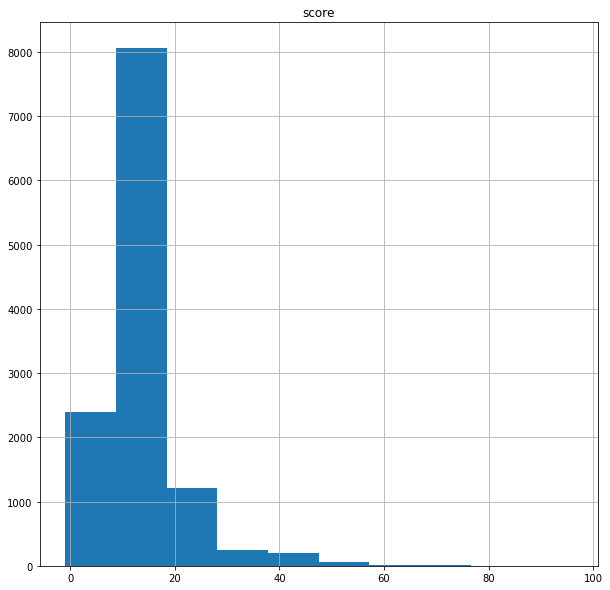

In [16]:
import matplotlib.pyplot as plt

df[['score']].hist(figsize=[10,10])
plt.show()

In [17]:
df.location

2               40.74454427,-73.91538981
3                40.71521417,-74.0112403
5               40.84861337,-73.91801844
6               40.65054499,-74.00463446
8        40.752067700000005,-73.85946867
                      ...               
24987           40.70180325,-73.80862151
24988           40.72913057,-74.00523166
24989           40.68639383,-73.95452826
24991              40.73306118,-73.99825
24996           40.75370382,-73.98704594
Name: location, Length: 12207, dtype: object

In [18]:
df.es_query({
    'geo_distance':{
        'distance':'5m',
        'location':{
            'lat':40.68639383,
            'lon':-73.95452826
        }
    }
})

,action,bbl,...,violation_description,zipcode
5914,Violations were cited in the following area(s).,3.019740e+09,...,"Food contact surface not properly washed, rins...",11216.0
24989,Violations were cited in the following area(s).,3.019740e+09,...,Plumbing not properly installed or maintained;...,11216.0


In [19]:
df.es_query({'match':{'dba':'red'}})

,action,bbl,...,violation_description,zipcode
447,Violations were cited in the following area(s).,4.032550e+09,...,Proper sanitization not provided for utensil w...,11375.0
7991,Violations were cited in the following area(s).,1.018640e+09,...,Plumbing not properly installed or maintained;...,10025.0
8128,Violations were cited in the following area(s).,1.019280e+09,...,Non-food contact surface improperly constructe...,10027.0
9372,Violations were cited in the following area(s).,1.000020e+09,...,Facility not vermin proof. Harborage or condit...,10004.0
6788,Violations were cited in the following area(s).,3.051410e+09,...,Evidence of rats or live rats present in facil...,11218.0
...,...,...,...,...,...
21028,Violations were cited in the following area(s).,1.000918e+09,...,Food not protected from potential source of co...,10038.0
22487,Violations were cited in the following area(s).,4.000520e+09,...,"Food contact surface not properly washed, rins...",11101.0
23380,Violations were cited in the following area(s).,4.068240e+09,...,Non-food contact surface improperly constructe...,11366.0
23878,Violations were cited in the following area(s).,4.032550e+09,...,"Food contact surface not properly washed, rins...",11375.0


In [20]:
df.es_query({'match':{'dba':'red'}}).dba

447                RED PIPE CAFE
7991             RED HOT HOT POT
8128                    RED STAR
9372     AUNTIE ANNE'S/RED MANGO
6788                    RED MIST
                  ...           
21028                  RED MANGO
22487                   RED CAFE
23380                  RED MANGO
23878              RED PIPE CAFE
24306           RED WHITE & BREW
Name: dba, Length: 32, dtype: object

In [21]:
df.es_query({'match':{'dba':'mango'}}).dba

9372     AUNTIE ANNE'S/RED MANGO
6651         MANGO MANGO DESSERT
7039                   RED MANGO
9033             RED MANGO #0484
17996        MANGO MANGO DESSERT
21028                  RED MANGO
22758      MANGO CREPES AND MORE
23380                  RED MANGO
Name: dba, dtype: object

In [22]:
sample_df = df[df.grade == 'A'].sample(100).to_pandas()
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 10016 to 9791
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   action                 100 non-null    object 
 1   bbl                    100 non-null    float64
 2   bin                    100 non-null    float64
 3   boro                   100 non-null    object 
 4   building               100 non-null    object 
 5   camis                  100 non-null    int64  
 6   census_tract           100 non-null    float64
 7   community_board        100 non-null    float64
 8   council_district       100 non-null    float64
 9   critical_flag          100 non-null    object 
 10  cuisine_description    100 non-null    object 
 11  dba                    100 non-null    object 
 12  grade                  100 non-null    object 
 13  grade_date             100 non-null    object 
 14  inspection_date        100 non-null    object 
 15  inspec

In [23]:
type(sample_df)

pandas.core.frame.DataFrame

# Machine Learning

In [24]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier

df = datasets.load_wine()
print("Feature Name: ", df.feature_names)
print("Data Example: ", df.data[0])

data = [x for i,x in enumerate(df.data) if i not in [10,80,140]]
target = [x for i,x in enumerate(df.target) if i not in [10,80,140]]

sk_classifier = DecisionTreeClassifier()
sk_classifier.fit(data, target)

print(sk_classifier.predict(df.data[[10,80,140]]))
print(df.target[[10,80,140]])

Feature Name:  ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
Data Example:  [1.423e+01 1.710e+00 2.430e+00 1.560e+01 1.270e+02 2.800e+00 3.060e+00
 2.800e-01 2.290e+00 5.640e+00 1.040e+00 3.920e+00 1.065e+03]
[0 1 2]
[0 1 2]


In [25]:
# pulls the model and serializes the vvalues inside the model and convert it into elasticsearch query
from eland.ml import ImportedMLModel

ed_classifier = ImportedMLModel(es_client=es,
                               model_id='wine-classifier',
                               model=sk_classifier,
                               feature_names=df.feature_names)

import logging
logger = logging.getLogger('elasticsearch')
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler())

print(ed_classifier.predict(df.data[[10,80,140]].tolist()))
print(df.target([[10,80,140]]))

logging_handlers=[]

AuthorizationException: AuthorizationException(403, 'security_exception', 'current license is non-compliant for [ml]')